# Load packages

In [1]:
import jax

import ssms
import torch
import pickle
import numpy as np
import os
import lanfactory
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from pymc.sampling import jax as pmj
import arviz

passing 1
wandb not available
wandb not available


# Check model parameters

In [2]:
ssms.config.model_config['angle']

{'name': 'angle',
 'params': ['v', 'a', 'z', 't', 'theta'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.001, -0.1], [3.0, 3.0, 0.9, 2.0, 1.3]],
 'boundary_name': 'angle',
 'boundary': <function ssms.basic_simulators.boundary_functions.angle(t=1, theta=1)>,
 'n_params': 5,
 'default_params': [0.0, 1.0, 0.5, 0.001, 0.0],
 'nchoices': 2,
 'simulator': <cyfunction ddm_flexbound at 0x7fc98d5b8d40>}

# Set up the functions for jax and pytensor wrapper

In [3]:
from os import PathLike
from typing import Callable, Tuple

import pytensor 
pytensor.config.floatX = "float32"
import pytensor.tensor as pt
import jax.numpy as jnp
from jax.scipy.special import expit
import numpy as np
from pytensor.graph import Apply, Op
from pytensor.link.jax.dispatch import jax_funcify
from jax import jit, vjp, vmap
from jax import grad, jit
from numpy.typing import ArrayLike

LogLikeFunc = Callable[..., ArrayLike]
LogLikeGrad = Callable[..., ArrayLike]

import pymc as pm
from pytensor.tensor.random.op import RandomVariable

import warnings 
warnings.filterwarnings('ignore')

class NetworkLike:
    @classmethod
    def make_logp_jax_funcs(
        cls,
        params_is_reg: list[bool],
        list_params: list,
        model = None,
        n_params: int | None = None,
        bounds = None,
        kind: str = 'lan',
    ) -> Tuple[LogLikeFunc, LogLikeGrad, LogLikeFunc,]:
        """Makes a jax log likelihood function from flax network forward pass.
        Args:
            model: A path or url to the ONNX model, or an ONNX Model object
            already loaded.
            compile: Whether to use jit in jax to compile the model.
        Returns: A triple of jax or Python functions. The first calculates the
            forward pass, the second calculates the gradient, and the third is
            the forward-pass that's not jitted.
        """
        if kind == 'lan':
            def logp_lan(data: np.ndarray, *dist_params) -> ArrayLike:
                """
                Computes the sum of the log-likelihoods given data and arbitrary
                numbers of parameters assuming the trial by trial likelihoods
                are derived from a LAN.
                Args:
                    data: response time with sign indicating direction.
                    dist_params: a list of parameters used in the likelihood computation.
                Returns:
                    The sum of log-likelihoods.
                """
                
                
                transformed_params = []
                for i in range(len(dist_params)):
                    if list_params[i] in bounds.keys():
                        transformed_params.append(expit(dist_params[i]) * (bounds[list_params[i]][1] - bounds[list_params[i]][0]) + bounds[list_params[i]][0])
                    else:
                        transformed_params.append(dist_params[i])
                input_matrix = jnp.concatenate((jnp.array(transformed_params[:-1]), data))

                ll = jnp.multiply(jnp.exp(model(input_matrix)),1-transformed_params[-1]) + transformed_params[-1] * 1/2.5

                # Network forward and sum
                return jnp.sum(
                    jnp.squeeze(jnp.log(ll))
                )
            # The vectorization of the logp function
            vmap_logp_lan = vmap(
                logp_lan,
                in_axes=[0] + [0 if is_regression else None for is_regression in params_is_reg],
            )
            # logp_grad_lan = grad(logp_lan, argnums=range(1, 1 + n_params))
            # return jit(logp_lan), jit(logp_grad_lan), logp_lan
            
            def vjp_vmap_logp_lan(
                data: np.ndarray, *dist_params: list[float | ArrayLike], gz: ArrayLike
            ) -> list[ArrayLike]:
                """Compute the VJP of the log-likelihood function.

                Parameters
                ----------
                data
                    A two-column numpy array with response time and response.
                dist_params
                    A list of parameters used in the likelihood computation.
                gz
                    The value of vmap_logp at which the VJP is evaluated, typically is just
                    vmap_logp(data, *dist_params)

                Returns
                -------
                list[ArrayLike]
                    The VJP of the log-likelihood function computed at gz.
                """
                _, vjp_fn = vjp(vmap_logp_lan, data, *dist_params)
                return vjp_fn(gz)[1:]

            return jit(vmap_logp_lan), jit(vjp_vmap_logp_lan), vmap_logp_lan

        elif kind == 'cpn':
            def logp_cpn(data: np.ndarray, *dist_params) -> ArrayLike:
                """
                Computes the sum of the log-likelihoods given data and arbitrary
                numbers of parameters assuming the trial-by-trial likelihood derive for a CPN.
                Args:
                    data: response time with sign indicating direction.
                    dist_params: a list of parameters used in the likelihood computation.
                Returns:
                    The sum of log-likelihoods.
                """

                # Makes a matrix to feed to the LAN model
                # n_nogo_go_condition = jnp.sum(data > 0)
                # n_nogo_nogo_condition = jnp.sum(data < 0)
                # n_omission = jnp.sum(data>0)
                # n_total = jnp.sum(data>=0)
                transformed_params = []

                for i in range(len(dist_params)):
                    if list_params[i] in bounds.keys():
                        transformed_params.append(expit(dist_params[i]) * (bounds[list_params[i]][1] - bounds[list_params[i]][0]) + bounds[list_params[i]][0])
                    else:
                        transformed_params.append(dist_params[i])
                        
                params_matrix  = jnp.array(transformed_params)

                # AF-TODO Bugfix here !
                # dist_params_nogo = jnp.stack(dist_params).reshape(1, -1)
                # dist_params_nogo = dist_params_nogo.at[0].set((-1) * dist_params_nogo[0])

                net_out = jnp.squeeze(model(params_matrix))

                # Include lapse distribution (uniform) into omission likelihood
                # dist_params[-1]: outlier
                # dist_params[-2]: deadline (in second)

                out = jnp.sum(jnp.multiply(jnp.log(1 - jnp.exp(net_out) + 1e-64),data))

                return out
            vmap_logp_cpn = vmap(
                logp_cpn,
                in_axes=[0] + [0 if is_regression else None for is_regression in params_is_reg],
            )
            def vjp_vmap_logp_cpn(
                data: np.ndarray, *dist_params: list[float | ArrayLike], gz: ArrayLike
            ) -> list[ArrayLike]:
                """Compute the VJP of the log-likelihood function.

                Parameters
                ----------
                data
                    A two-column numpy array with response time and response.
                dist_params
                    A list of parameters used in the likelihood computation.
                gz
                    The value of vmap_logp at which the VJP is evaluated, typically is just
                    vmap_logp(data, *dist_params)

                Returns
                -------
                list[ArrayLike]
                    The VJP of the log-likelihood function computed at gz.
                """
                _, vjp_fn = vjp(vmap_logp_cpn, data, *dist_params)
                return vjp_fn(gz)[1:]

            return jit(vmap_logp_cpn), jit(vjp_vmap_logp_cpn), vmap_logp_cpn

    @staticmethod

    def make_jax_logp_ops(
        logp: LogLikeFunc,
        logp_vjp: LogLikeGrad,
        logp_nojit: LogLikeFunc,
    ) -> Op:
        """Wrap the JAX functions and its gradient in pytensor Ops.

        Parameters
        ----------
        logp
            A JAX function that represents the feed-forward operation of the LAN
            network.
        logp_vjp
            The Jax function that calculates the VJP of the logp function.
        logp_nojit
            The non-jit version of logp.

        Returns
        -------
        Op
            An pytensor op that wraps the feed-forward operation and can be used with
            pytensor.grad.
        """

        class LANLogpOp(Op):  # pylint: disable=W0223
            """Wraps a JAX function in an pytensor Op."""

            def make_node(self, data, *dist_params):
                """Take the inputs to the Op and puts them in a list.

                Also specifies the output types in a list, then feed them to the Apply node.

                Parameters
                ----------
                data
                    A two-column numpy array with response time and response.
                dist_params
                    A list of parameters used in the likelihood computation. The parameters
                    can be both scalars and arrays.
                """
                inputs = [
                    pt.as_tensor_variable(data),
                ] + [pt.as_tensor_variable(dist_param) for dist_param in dist_params]

                outputs = [pt.vector()]

                return Apply(self, inputs, outputs)

            def perform(self, node, inputs, output_storage):
                """Perform the Apply node.

                Parameters
                ----------
                inputs
                    This is a list of data from which the values stored in
                    output_storage are to be computed using non-symbolic language.
                output_storage
                    This is a list of storage cells where the output
                    is to be stored. A storage cell is a one-element list. It is
                    forbidden to change the length of the list(s) contained in
                    output_storage. There is one storage cell for each output of
                    the Op.
                """
                result = logp(*inputs)
                output_storage[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

            def grad(self, inputs, output_gradients):
                """Perform the pytensor.grad() operation.

                Parameters
                ----------
                inputs
                    The same as the inputs produced in `make_node`.
                output_gradients
                    Holds the results of the perform `perform` method.

                Notes
                -----
                    It should output the VJP of the Op. In other words, if this `Op`
                    outputs `y`, and the gradient at `y` is grad(x), the required output
                    is y*grad(x).
                """
                results = lan_logp_vjp_op(inputs[0], *inputs[1:], gz=output_gradients[0])
                output = [
                    pytensor.gradient.grad_not_implemented(self, 0, inputs[0]),
                ] + results

                return output

        class LANLogpVJPOp(Op):  # pylint: disable=W0223
            """Wraps the VJP operation of a jax function in an pytensor op."""

            def make_node(self, data, *dist_params, gz):
                """Take the inputs to the Op and puts them in a list.

                Also specifies the output types in a list, then feed them to the Apply node.

                Parameters
                ----------
                data:
                    A two-column numpy array with response time and response.
                dist_params:
                    A list of parameters used in the likelihood computation.
                """
                inputs = (
                    [
                        pt.as_tensor_variable(data),
                    ]
                    + [pt.as_tensor_variable(dist_param) for dist_param in dist_params]
                    + [pt.as_tensor_variable(gz)]
                )
                outputs = [inp.type() for inp in inputs[1:-1]]

                return Apply(self, inputs, outputs)

            def perform(self, node, inputs, outputs):
                """Perform the Apply node.

                Parameters
                ----------
                inputs
                    This is a list of data from which the values stored in
                    `output_storage` are to be computed using non-symbolic language.
                output_storage
                    This is a list of storage cells where the output
                    is to be stored. A storage cell is a one-element list. It is
                    forbidden to change the length of the list(s) contained in
                    output_storage. There is one storage cell for each output of
                    the Op.
                """
                results = logp_vjp(inputs[0], *inputs[1:-1], gz=inputs[-1])

                for i, result in enumerate(results):
                    outputs[i][0] = np.asarray(result, dtype=node.outputs[i].dtype)

        lan_logp_op = LANLogpOp()
        lan_logp_vjp_op = LANLogpVJPOp()

        # Unwraps the JAX function for sampling with JAX backend.
        @jax_funcify.register(LANLogpOp)
        def logp_op_dispatch(op, **kwargs):  # pylint: disable=W0612,W0613
            return logp_nojit

        return lan_logp_op


# Load LAN

In [4]:
# Loaded Net
model_config = ssms.config.model_config['angle']

jax_infer_lan = lanfactory.trainers.MLPJaxFactory(
    network_config="../network/angle/lan/96f2b24a933211ee99b9a0423f3e9a40_lan_angle__network_config.pickle",
    train=False,
)

forward_pass_lan, forward_pass_jitted_lan = jax_infer_lan.make_forward_partial(
    seed=42,
    input_dim=model_config["n_params"] + 2,
    state="../network/angle/lan/96f2b24a933211ee99b9a0423f3e9a40_lan_angle__train_state.jax",
    add_jitted=True,
)

passing through identity


# Load OPN

In [ ]:
# Loaded Net
jax_infer_cpn = lanfactory.trainers.MLPJaxFactory(
    network_config="../network/angle/cpn/338ff01ca91911ee91a3a0423f3e9b42_cpn_angle__network_config.pickle",
    train=False,
)

forward_pass_cpn, forward_pass_jitted_cpn = jax_infer_cpn.make_forward_partial(
    seed=42,
    input_dim=model_config["n_params"] + 1,
    state="../network/angle/cpn/338ff01ca91911ee91a3a0423f3e9b42_cpn_angle__train_state.jax",
    add_jitted=True,
)

# This is the part I loaded the dataset. You can ignore this part.

In [5]:
df = pd.read_csv('~/PAAT_ddm_2024-05-09.csv')

In [6]:
df.response = df.response * 2 - 1
df['subject'] = df['SubID'].factorize()[0]
df.subject.unique()
df.response.unique()

array([-1,  1])

# Create the pytensor OP

In [7]:
# Instantiate LAN logp functions
lan_logp_jitted, lan_logp_vjp_jitted, lan_logp = NetworkLike.make_logp_jax_funcs(model = forward_pass_lan,
                                                                                  n_params = 6,
                                                                                  kind = "lan",
                                                                                  list_params = ['v','a','z','t','theta','p_outlier'],
                                                                                  bounds = {'v':(-3,3),
                                                                                            'a':(0.2,3),
                                                                                            'z':(0.1,0.9),
                                                                                            't':(0.01,1),
                                                                                            'theta':(0,1.2),
                                                                                            'p_outlier':(0,0.05)},
                                                                                  params_is_reg=[True,True,True,True,True,False])

# Turn into logp op
lan_logp_op = NetworkLike.make_jax_logp_ops(
                                logp = lan_logp_jitted,
                                logp_vjp = lan_logp_vjp_jitted,
                                logp_nojit = lan_logp)

# Run the fitting

In [10]:
coords = {
    "id": df.subject.unique(),  # actual group names
    "observation": np.arange(df.shape[0])
}

jax.config.update("jax_enable_x64", False)

In [ ]:
with pm.Model(coords=coords) as hierarchical:
    # Hyperpriors
    mu_v = pm.Normal('mu_v',mu=0,sigma=1)
    sigma_v = pm.Uniform('sigma_v',lower=0.01,upper=10)
    v_subj = pm.Normal('v_subj',mu=mu_v,sigma=sigma_v,dims='id')
 
    mu_theta = pm.Normal('mu_theta',mu=0,sigma=1)
    sigma_theta = pm.Uniform('sigma_theta',lower=0.01,upper=10)
    theta_subj = pm.Normal('theta_subj',mu=mu_theta,sigma=sigma_theta,dims='id')
    
    mu_a = pm.Normal('mu_a',mu=0,sigma=1)
    sigma_a = pm.Uniform('sigma_a',lower=0.01,upper=10)
    a_subj = pm.Normal('a_subj',mu=mu_theta,sigma=sigma_theta,dims='id')
        
    mu_z = pm.Normal("mu_z", mu=0,sigma=1)
    sigma_z = pm.Uniform("sigma_z",lower=0.01,upper=10)
    z_subj = pm.Normal("z_subj", mu=mu_z,sigma=sigma_z,dims='id')
    
    mu_t = pm.Normal("mu_t", mu=0,sigma=1)
    sigma_t = pm.Uniform("sigma_t",lower=0.01,upper=10)
    t_subj = pm.Normal("t_subj", mu=mu_t,sigma=sigma_t,dims='id')
    
    mu_p = pm.Normal("mu_p", mu=0,sigma=1)
    sigma_p = pm.Uniform("sigma_p",lower=0.01,upper=10)
    p_subj = pm.Normal("p_subj", mu=mu_p,sigma=sigma_p,dims='id')
    
    idx1 = pm.ConstantData('idx1',df.subject,dims='observation')
    
    v_trial1 = pm.Deterministic('v_trial1',v_subj[idx1])
    a_trial1 = pm.Deterministic('a_trial1',a_subj[idx1])
    theta_trial1 = pm.Deterministic('theta_trial1',theta_subj[idx1])
    z_trial1 = pm.Deterministic('z_trial1',z_subj[idx1])
    t_trial1 = pm.Deterministic('t_trial1',t_subj[idx1])
    p_trial1 = pm.Deterministic('p_trial1',p_subj[idx1])

    pm.CustomDist("choice_rt", v_trial1,a_trial1,
                                          z_trial1, 
                                          t_trial1, 
                                          theta_trial1,
                                          p_trial1,
                 logp=lan_logp_op,observed=df[['rt','response']]) 
    ddm_blog_traces_numpyro_d = pmj.sample_numpyro_nuts(target_accept=0.9,
            chains=2, draws=1000, tune=500,initvals={'mu_v':0,'mu_a':0,'mu_theta':0,"mu_z":0,"mu_t":0,'mu_p':0}
    )

passing through identity


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

passing through identity


# Function to extract and plot traces that I'm interested in

In [29]:
def mytraceplot(trace):
    keep = [x for x in trace.posterior.data_vars.keys() if x[-6:-1] != 'trial']
    pm.plot_trace(trace, keep, compact=True)

    
def mysummary(trace):
    keep = [x for x in trace.posterior.data_vars.keys() if x[-6:-1] != 'trial']
    return pm.summary(trace, keep)

OverflowError: cannot convert float infinity to integer

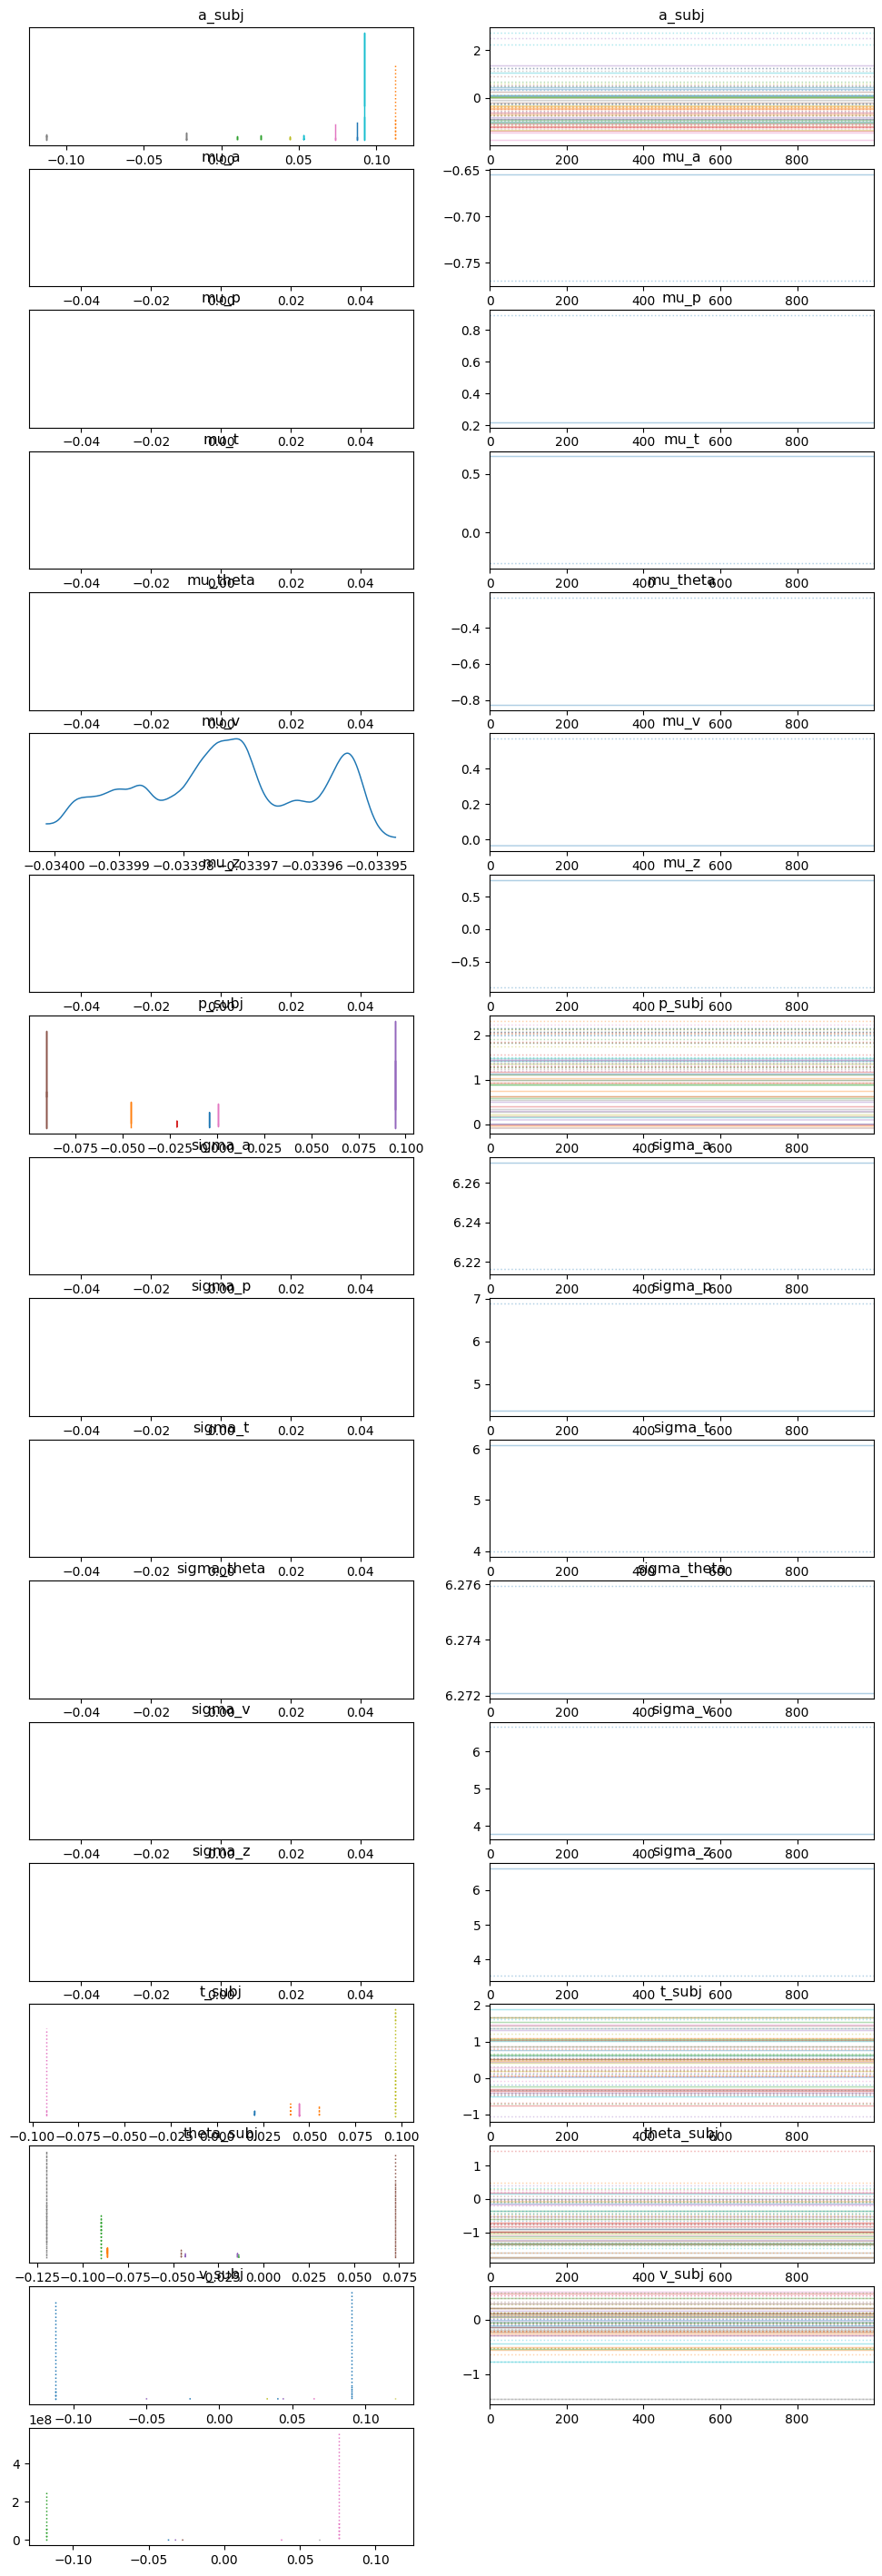

In [30]:
import pymc as pm

a = mytraceplot(ddm_blog_traces_numpyro_d)
plt.tight_layout()

In [28]:
print(1)

1


# Tried to estimate LL from model

In [59]:
with hierarchical:
    a = pm.compute_log_likelihood(ddm_blog_traces_numpyro_d)

In [64]:
pm.waic(a,var_name='omission')

Computed from 400 posterior samples and 164376 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -17555.59   256.33
p_waic      715.00        -

There has been a warning during the calculation. Please check the results.